# Converting between wind speed averaging periods

This notebook demonstrates the derivation of the wind speed conversion factors published in the World Meteorological Organisation's *Guidelines for Converting Between Various Wind Averaging Periods in Tropical Cyclone Conditions* ([WMO TD1555, 2010](http://www.wmo.int/pages/prog/www/tcp/documents/WMO_TD_1555_en.pdf)). 

We follow the methods outlined in Appendix D *The Modified ESDU Gust Factor Method*, which establishes a procedure for estimating the peak factor $g$, in combination with an *a priori* estimate of the turbulence intensity $I_u$ to estimate the appropriate gust factor $G$ for TC conditions.

This extends the wind speed averaging times to 0.2 seconds, following the recommendations of Holmes and Ginger (2012), where the previously defined '3-second' gust (average wind over 3 seconds) measured by Dines anemometers is in fact considered representative of a 0.2-second gust, due to the response characteristics of the instrument. 

#### Definition of the gust factor

The gust factor to be defined is given by Eq. 14 in TD 1555:

$G_{\tau, T_o} = \dfrac{V_{\tau}}{V_{T_o}} = 1 + g_{\tau, T_o} I_u$

where:

* $\tau$ is the averaging period of the gust wind;
* $T_o$ is the reference period of the wind;
* $V_{\tau}$ is the gust wind speed;
* $V_{T_o}$ is the mean wind speed estimate;
* $g_{\tau, T_o}$ is the peak factor;
* $G_{\tau, T_o}$ is the gust factor; and
* $I_u$ is the turbulence intensity
    
First start with importing the required Python modules.

In [1]:
from __future__ import division
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context("paper")

The approach starts with estimating the spectrally-based zero-crossing rate $\nu$, relative to an *hourly* reference period $T'_o$:

$\nu(\tau, T'_o) = \dfrac{[0.007 + 0.213(T_u/\tau)^{0.654}]}{T_u}$

The integral time scale of the longitudinal turbulence $T_u$ is approximated empirically as a function of the elevation $z$:

$T_u = 3.13z^{0.2}$

In [2]:
def crossingRate(tau, eta=10.):
    Tu = 3.13 * np.power(eta, 0.2)
    nu = (0.007 + 0.213 * np.power(Tu / tau, 0.654)) / Tu
    return nu

We assume $z=10$ metres throughout, and the ratio of the standard deviations of the gust and instantaneous winds can be defined as:

$\dfrac{\sigma_u (\tau, T'_o)}{\sigma_u} = 1 - 0.193[\dfrac{T_u}{\tau} + 0.1]^{-0.68}$. 

The mean of the maximum values of the gust within an hourly reference period $V_{\tau, T'_o}$ is obtained from:

$\dfrac{V_{\tau, T'_o}}{\sigma_u (\tau, T'_o)} = 
    \sqrt{2 \ln[T'_o \nu(\tau, T'_o)]} + \dfrac{0.577}{\sqrt{2 \ln[T'_o \nu(\tau, T'_o)]}}$

These are then combined to give the peak factor $g$:

$g_{\tau, T'_o} = \dfrac{V_{\tau, T'_o}}{\sigma_u (\tau, T'_o)} \dfrac{\sigma_u (\tau, T'_o)}{\sigma_u}$

and then:

$G_{\tau, T'_o} = 1 + g_{\tau, T'_o} I_u$ 


In [3]:
def gustFactor(tau, turbulence, reftime=3600., elev=10.):
    nu = crossingRate(tau, elev)
    Tu = 3.13 * np.power(elev, 0.2)
    sdratio = 1. - 0.193 * np.power((Tu / tau) + 0.1, -0.68)
    v_tau = np.sqrt(2. * np.log(reftime * nu)) + \
        0.577 / np.sqrt(2. * np.log(reftime * nu))
    g = v_tau * sdratio
    return 1. + g * turbulence

The ESDU $G_{T_o}$ function, taken from Figure 2b ([ESDU, 2002][ESDU2002]), allows for $G_{\tau, T'_o}$ to be modified to permit a reference period $T_o$ that is other than the hourly $T'_o$:

$G_{T_o} = \dfrac{G_{\tau, T_o}}{G_{\tau, T'_o}}$

The $G_{T_o}$ function is approximated by this relationship:

[ESDU2002]: https://www.esdu.com/cgi-bin/ps.pl?sess=unlicensed_1150818225520wyk&t=doc&p=esdu_83045c-r1

In [4]:
def esdu_gto(reftime):
    gto = 0.2193 * np.log(np.log10(reftime)) + 0.7242
    return gto

The final step is then to define the gust factor for a selected reference period $T_o$ and gust averaging period $\tau$:

$G_{\tau, T_o} = G_{T_o} G_{\tau, T'_o}$


Here we calculate the wind speed conversion factors for a range of time periods. The base reference time is 600 seconds (10 minutes), but can be modified to suit the application. This step also applies the ESDU function $G_{T_o}$, and sets all values less than 1.0 equal to 1.0. We demonstrate wind speed conversion factors for a range of turbulence intensities, approximating the conditions described in Table 1.1 in TD1555.

In [5]:
reftime = 600.
tau = np.array([0.1, 0.2, .5, 1., 3., 10., 30., 60., 120., 180., 600., 3600.])
eta = 10.

gto = esdu_gto(reftime)

gf_inland = gustFactor(tau, 0.25, reftime) * gto
gf_offland = gustFactor(tau, 0.2, reftime) * gto
gf_offsea = gustFactor(tau, 0.15, reftime) * gto
gf_atsea = gustFactor(tau, 0.1, reftime) * gto

gf_inland = np.where(gf_inland < 1., 1., gf_inland)
gf_offland = np.where(gf_offland < 1., 1., gf_offland)
gf_offsea = np.where(gf_offsea < 1., 1., gf_offsea)
gf_atsea = np.where(gf_atsea < 1., 1., gf_atsea)

Plot the results:

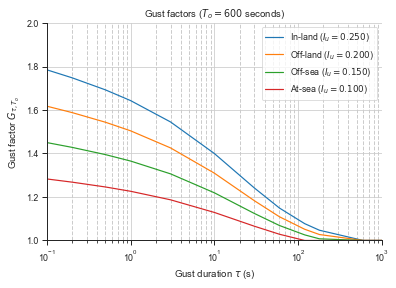

In [6]:
plt.semilogx(tau, gf_inland, label=r"In-land ($I_u=0.250$)")
plt.semilogx(tau, gf_offland, label=r"Off-land ($I_u=0.200$)")
plt.semilogx(tau, gf_offsea, label=r"Off-sea ($I_u=0.150$)")
plt.semilogx(tau, gf_atsea, label=r"At-sea ($I_u=0.100$)")
plt.title("Gust factors ($T_o = {:.0f}$ seconds)".format(reftime))
plt.legend(frameon=True)
plt.ylim((1.0, 2.0))
plt.xlim((0.1, 1000))
plt.ylabel(r'Gust factor $G_{\tau, T_o}$')
plt.xlabel(r'Gust duration $\tau$ (s)')
plt.grid(which='major')
plt.grid(which='minor', linestyle='--', linewidth=1)
plt.legend()
sns.despine()

Print a formatted table of the conversion factors

In [7]:
titlestr = "Duration| " + "| ".join(['{:6.1f}']*len(tau)).format(*tau)
print(titlestr)

rowfmt = "{:s}| " + "| ".join(['{:6.3f}']*len(tau))
print(rowfmt.format("In-land ", *gf_inland))
print(rowfmt.format("Off-land", *gf_offland))
print(rowfmt.format("Off-sea ", *gf_offsea))
print(rowfmt.format("At-sea  ", *gf_atsea))

Duration|    0.1|    0.2|    0.5|    1.0|    3.0|   10.0|   30.0|   60.0|  120.0|  180.0|  600.0| 3600.0
In-land |  1.785|  1.748|  1.693|  1.643|  1.545|  1.400|  1.242|  1.149|  1.077|  1.047|  1.000|  1.000
Off-land|  1.617|  1.588|  1.544|  1.504|  1.426|  1.310|  1.183|  1.109|  1.052|  1.027|  1.000|  1.000
Off-sea |  1.450|  1.428|  1.395|  1.365|  1.306|  1.219|  1.124|  1.069|  1.026|  1.008|  1.000|  1.000
At-sea  |  1.283|  1.268|  1.246|  1.226|  1.187|  1.129|  1.066|  1.029|  1.000|  1.000|  1.000|  1.000


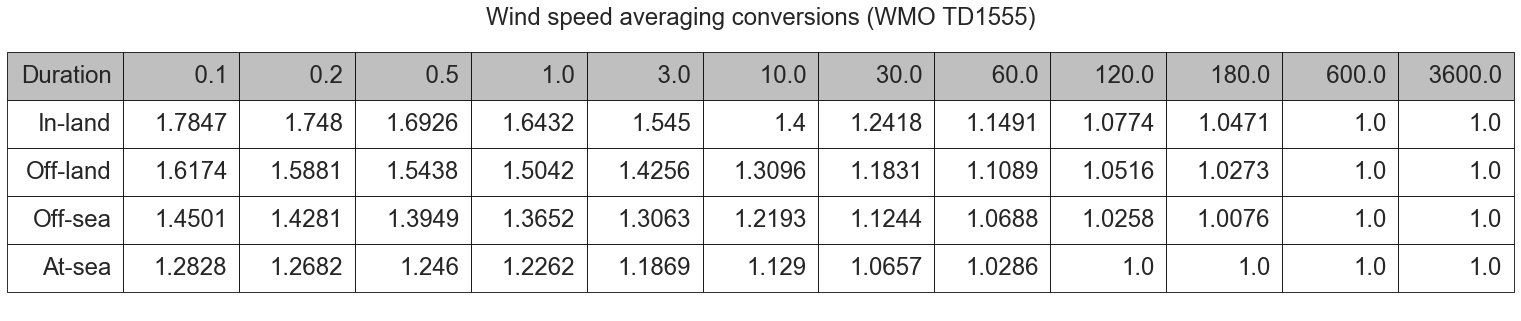

In [8]:
nrows = 5
ncols = len(tau) + 1
hcell, wcell = 1., 1.
hpad, wpad = .2, 0.5
fig, ax = plt.subplots(figsize=((ncols*wcell+wpad), (nrows*hcell+hpad)))
ax.axis('off')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for sp in ax.spines.items():
    sp[1].set_color('w')
    sp[1].set_zorder(0)

titlestr = "Duration| " + "| ".join(['{:6.1f}'] * len(tau)).format(*tau)
columns = titlestr.split('|')
cell_text = [columns]
cell_colors = [['0.75']*len(columns)]
cell_text.append(["In-land"] + list(gf_inland.round(4)))
cell_text.append(["Off-land"] + list(gf_offland.round(4)))
cell_text.append(["Off-sea"] + list(gf_offsea.round(4)))
cell_text.append(["At-sea"] + list(gf_atsea.round(4)))
cell_colors.append(['w']*len(columns))
cell_colors.append(['w']*len(columns))
cell_colors.append(['w']*len(columns))
cell_colors.append(['w']*len(columns))
the_table = plt.table(cellText=cell_text, loc='center',
                      fontsize=24, cellColours=cell_colors)
the_table.set_zorder(10)
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 4)
ax.set_title("Wind speed averaging conversions (WMO TD1555)", fontsize=24)
plt.show()

*With thanks to Bruce Harper, Systems Engineering Australia.*

In [9]:
def print_conversions(avgper):
    tauidx = np.where(tau==avgper)[0]
    titlestr = "Duration| " + "| ".join(['{:6.1f}']*len(tau)).format(*tau)
    print(titlestr)
    print("-"*len(titlestr))
    rowfmt = "{:s}| " + "| ".join(['{:6.3f}']*len(tau))
    print(rowfmt.format("In-land ", *gf_inland/gf_inland[tauidx]))
    print(rowfmt.format("Off-land", *gf_offland/gf_offland[tauidx]))
    print(rowfmt.format("Off-sea ", *gf_offsea/gf_offsea[tauidx]))
    print(rowfmt.format("At-sea  ", *gf_atsea/gf_atsea[tauidx]))
    

In [10]:
from ipywidgets import interactive
import ipywidgets as widgets
tau_select = widgets.Dropdown(options=list(tau), value=tau[4], 
                              description="Averaging period (s)")
w = interactive(print_conversions, avgper=tau_select)
w

interactive(children=(Dropdown(description='Averaging period (s)', index=4, options=(0.1, 0.2, 0.5, 1.0, 3.0, …